# Settting Up

In [9]:
import h5py
import numpy as np
import matplotlib.pyplot as plt
import os
os.chdir('C:\\Users\\User\\Desktop\\Internship')
data_path = 'data.h5'
data = h5py.File(data_path, 'r') 
import random
from feedback_loop import Feedback
from extras import get_predictions

N = 35 # length of lagged stim vector, how many past times we want it to depend on, N can be set to equal t if we want to consider all past values 
M = 35 #lenght of EEG feedback vector 
x = np.hstack([data[f'stim/part{0}'][:]])

Y_t_allelectrodes = np.hstack([data[f'eeg/P00/part{0}'][:]]) #only looking at participant P00. but this is for all electrodes 
y = Y_t_allelectrodes[51] #update for speicific electrode  

from scipy.stats import pearsonr

'''model parameters'''
np.random.seed(0)
k = np.random.normal(0, 0.01, N) 

np.random.seed(1)
h = np.random.normal(0, 0.01, M)

print(data.keys())
print(data['eeg'].keys())
print(data['stim'].keys())
plt.rcParams["figure.figsize"] = (12, 8)

ch_names = ['AF3', 'AF4', 'AF7', 'AF8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'Fp1', 'Fp2', 'FT10', 'FT7', 'FT8', 'FT9', 'Fz', 'O1', 'O2', 'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'FCz', 'T7', 'T8', 'TP10', 'TP7', 'TP8', 'TP9', 'AFz']

<KeysViewHDF5 ['eeg', 'stim']>
<KeysViewHDF5 ['P00', 'P01', 'P010', 'P011', 'P012', 'P02', 'P03', 'P04', 'P05', 'P06', 'P07', 'P08', 'P09']>
<KeysViewHDF5 ['part0', 'part1', 'part10', 'part11', 'part12', 'part13', 'part14', 'part2', 'part3', 'part4', 'part5', 'part6', 'part7', 'part8', 'part9']>


# EEG reconstruction 

In [7]:
def plot_eeg_recon(participant):

    
    train_parts = range(1)
    test_parts = range(11,12)
    electrode_idx = 56 # a number between 1 and 64

    y_train = np.hstack([data[f'eeg/{participant}/part{part}'][:] for part in train_parts])
    x_train = np.hstack([data[f'stim/part{part}'][:] for part in train_parts])
    
    predictions = get_predictions(k,h,x_train, 20271) 
   
    mdl = Feedback(35, 35, k, h, 1e-7, 1e-7) #should this be changed too? 
    mdl.fit(x_train, y_train[electrode_idx], k, h, predictions)

    y_test = np.hstack([data[f'eeg/{participant}/part{part}'][:] for part in test_parts])
    x_test = np.hstack([data[f'stim/part{part}'][:] for part in test_parts])

    y_hat = mdl.predict(x_test)
    print(pearsonr(y_hat.flatten(), y_test[electrode_idx]))

    scores = []
    for electrode_idx in range(64):
        mdl.fit(x_train, y_train[electrode_idx], k, h, predictions)
        y_hat = mdl.predict(x_test, )
        scores.append(pearsonr(y_hat.flatten(), y_test[electrode_idx])[0])

    
    plt.plot(range(len(ch_names)), scores, label=f'{participant}')
    plt.xlabel('channel name')
    plt.ylabel('correlation coefficient')
    plt.title('eeg recon')
    plt.xticks(range(len(ch_names)), ch_names, rotation=90)  

(-0.06924611401162865, 1.2712898527512987e-18)


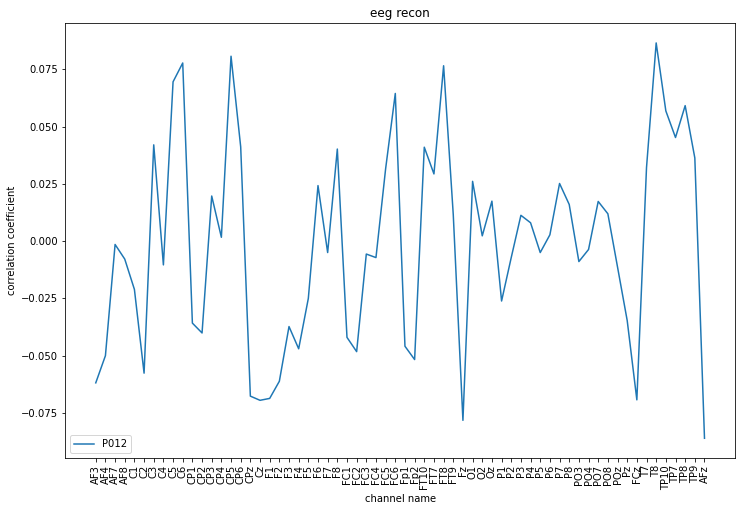

In [10]:
plt.close()
for participant in ['P012']: 
    plot_eeg_recon(participant)
plt.legend(loc ='lower left')
plt.show()

# Plotting correlation coefficients

In [ ]:
mdl = Feedback(35, 35, k, h, 1e-7, 1e-7)
train_parts = range(1)
participants = []
for participant in ['P012']: 
    coefficients=[]
    y_train = np.hstack([data[f'eeg/{participant}/part{part}'][:] for part in train_parts])
    x_train = np.hstack([data[f'stim/part{part}'][:] for part in train_parts])
    for electrode_idx in range(64):
            A=mdl.fit(x_train, y_train[electrode_idx],k, h, predictions)
            coefficients.append(A)
    coefficients = np.stack(coefficients, axis=0)
    coefficients = np.squeeze(coefficients)
    participants.append(coefficients)
participants = np.stack(participants, axis = 0)
participants = participants.mean(axis =0)

In [ ]:

participants_= participants.mean(axis =0)
print(participants_.shape)

plt.close()
seconds = np.arange(35)/125*1000
print(seconds.shape)

plt.plot(seconds, np.transpose(participants_))
plt.xlabel('latency (ms)')
plt.ylabel('coefficient')
plt.title('Model Coefficients') 
plt.legend(('k','h'), loc ='lower left')
plt.show()

In [ ]:
'''splitting participant array into k and h'''
a = np.split(participants, 2, axis=1)
k_ = a[0]
h_ = a[1]

k_ =np.stack(k_)
K = np.squeeze(k_)
h_ = np.stack(h_)
H = np.squeeze(h_)

In [ ]:
import mne
ch_names = ['AF3', 'AF4', 'AF7', 'AF8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'Fp1', 'Fp2', 'FT10', 'FT7', 'FT8', 'FT9', 'Fz', 'O1', 'O2', 'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'FCz', 'T7', 'T8', 'TP10', 'TP7', 'TP8', 'TP9', 'AFz']
info = mne.create_info(ch_names, 125, ch_types='eeg', verbose=None)
mne.channels.make_standard_montage('standard_1020')
info.set_montage('standard_1020')
evoked= mne.EvokedArray(K, info, tmin=0, comment='', nave=1, kind='average', baseline=None, verbose=None)

figure = evoked.plot_joint()

In [ ]:
ch_names = ['AF3', 'AF4', 'AF7', 'AF8', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'CP1', 'CP2', 'CP3', 'CP4', 'CP5', 'CP6', 'CPz', 'Cz', 'F1', 'F2', 'F3', 'F4', 'F5', 'F6', 'F7', 'F8', 'FC1', 'FC2', 'FC3', 'FC4', 'FC5', 'FC6', 'Fp1', 'Fp2', 'FT10', 'FT7', 'FT8', 'FT9', 'Fz', 'O1', 'O2', 'Oz', 'P1', 'P2', 'P3', 'P4', 'P5', 'P6', 'P7', 'P8', 'PO3', 'PO4', 'PO7', 'PO8', 'POz', 'Pz', 'FCz', 'T7', 'T8', 'TP10', 'TP7', 'TP8', 'TP9', 'AFz']
info = mne.create_info(ch_names, 125, ch_types='eeg', verbose=None)
mne.channels.make_standard_montage('standard_1020')
info.set_montage('standard_1020')
evoked= mne.EvokedArray(H, info, tmin=0, comment='', nave=1, kind='average', baseline=None, verbose=None)

figure = evoked.plot_joint()